<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/Competition_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [158]:
from google.colab import drive

DRIVE_MOUNT = './DRIVE/'
DRIVE_MOUNT_SAVE_MODEL_PATH = 'My Drive/Colab Notebooks/ns-2_task-6'
drive.mount(DRIVE_MOUNT, force_remount=True)



Mounted at ./DRIVE/


In [0]:
!rm -rf input

In [0]:
!mkdir input \
&& unzip "./DRIVE/My Drive/Colab Notebooks/ns-2_task-6/test.zip" -d input/test \
 && unzip "./DRIVE/My Drive/Colab Notebooks/ns-2_task-6/train.zip" -d input/train \
 && cp "./DRIVE/My Drive/Colab Notebooks/ns-2_task-6/sample_submission.csv" input \
 && cp "./DRIVE/My Drive/Colab Notebooks/ns-2_task-6/train_labels.csv" input \

Archive:  ./DRIVE/My Drive/Colab Notebooks/ns-2_task-6/test.zip
   creating: input/test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/
   creating: input/test/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac/
   creating: input/test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/
   creating: input/test/0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925/
   creating: input/test/0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6/
   creating: input/test/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/
   creating: input/test/1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c/
   creating: input/test/17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff/
   creating: input/test/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b/
   creating: input/test/191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829/
   creating: input/test/1962d0c5faf3

# Nucleus Detection
![](https://storage.googleapis.com/kaggle-media/competitions/dsb-2018/dsb.jpg)

# 0. Intro
### Основная идея: Делаем решение на базе U-Net

In [159]:
import os
import sys
import glob
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Adamax

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.6.8 (default, Jan 14 2019, 11:02:34) 
Numpy        : 1.16.5
Skimage      : 0.15.0
Keras        : 2.2.5
Tensorflow   : 1.14.0


In [0]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

# SETUP

In [0]:
# SETUP
TRAIN_PATH = 'input/train/'
TEST_PATH = 'input/test/'

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 3

BATCH_SIZE      = 32
NUM_EPOCHS      = 50

STEPS_PER_EPOCH = 600
LR              = 0.001
validation_split= 0.1

# 1. Load Data

Для начала глянем csv

In [162]:
sample_submission = pd.read_csv('input/sample_submission.csv')
sample_submission.sample(5)

ImageId EncodedPixels
53  d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...           1 1
60  eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...           1 1
0   0114f484a16c152baa2d82fdd43740880a762c93f436c8...           1 1
45  a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...           1 1
5   0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...           1 1

In [163]:
len(sample_submission)

65

Не кажеться странным, что нам предлагают на тест только 65 уникальных картинок? )  
посмотрим что в трейне...

In [164]:
train_labels = pd.read_csv('input/train_labels.csv')
train_labels.sample(10)

ImageId                                      EncodedPixels
16141  8b77284d6f37ab3fc826139ebadaec3b9d81c552fe525c...  55530 7 55784 12 56039 14 56294 16 56549 18 56...
27194  ea94ba4b01d1bd5f7768d10e0ac547743791033df545c7...  12295 8 12550 11 12805 14 13060 17 13316 18 13...
24216  cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9...  37435 5 37690 7 37945 8 38201 8 38457 8 38713 ...
25304  da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e751...  18647 6 19166 8 19686 9 20206 9 20726 8 21247 ...
21273  b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d4...  331026 5 331543 9 332062 12 332580 15 333099 1...
9796   538b7673d507014d83af238876e03617396b70fe27f525...  127462 4 128064 8 128666 12 129268 16 129870 2...
3410   1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526...  431986 4 433009 5 434033 5 435057 6 436081 6 4...
16126  8aa1a883f61f0bb5af3d3d60acaaf33af45ef4fbffaac1...  59092 3 59345 8 59600 11 59856 11 60112 11 603...
9577   4e23ecf65040f86420e0201134e538951acdeda84fbb27...  55041 2 55297 4 55553 5 55809 6 56065 6 56321 ...
27756  ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5...            23588 3 23843 5 24099 5 24355 5 24612 3

In [165]:
len(train_labels)

29461

в описании датасета написано что "Каждая маска содержит одно ядро."  
А из всех 29к примеров, сколько у нас уникальных изображений для тренировки на самом деле?

In [166]:
len(train_labels) - train_labels.ImageId.duplicated().sum()

670

Сверяем по папкам

In [167]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))
test_ids = next(os.walk(TEST_PATH))

mask_count = 0
for train_id in train_ids[1]:
    masks = next(os.walk(TRAIN_PATH + train_id + '/masks/'))[2]
    mask_count += len(masks)

print('There are {} images.'.format(len(train_ids[1])))
print('There are {} masks.'.format(mask_count))
print('Approximately {} masks per image.'.format(mask_count // len(train_ids[1])))

There are 670 images.
There are 29461 masks.
Approximately 43 masks per image.


Вот все и встало на свои места, Итого 65 изображений на тесте и 670 на трейне.  
Давай подгрузим и посмотрим эти картинки

In [0]:
# для подгрузки данных будем использовать удобную либу skimage
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    def img_transforms(path):
        return skimage.transform.resize(
            skimage.io.imread(path)[:,:,:3],
            output_shape=output_shape,
            mode='constant', 
            preserve_range=True,
        )
    X_data = np.array([img_transforms(path) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data

(670, 256, 256, 3) uint8


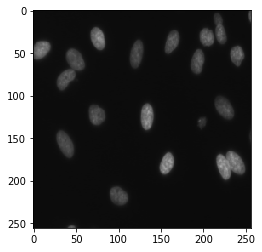

CPU times: user 21.1 s, sys: 16.5 s, total: 37.7 s
Wall time: 19.7 s


In [169]:
%%time
# Get training data
X_train = get_X_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(X_train.shape, X_train.dtype)

plt.imshow(X_train[0])
plt.show()
plt.pause(.01)

In [0]:
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data

In [171]:
%%time
# Get training data labels
Y_train = get_Y_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(Y_train.shape, Y_train.dtype)

(670, 256, 256, 1) bool
CPU times: user 1min 1s, sys: 30.5 s, total: 1min 31s
Wall time: 59.3 s


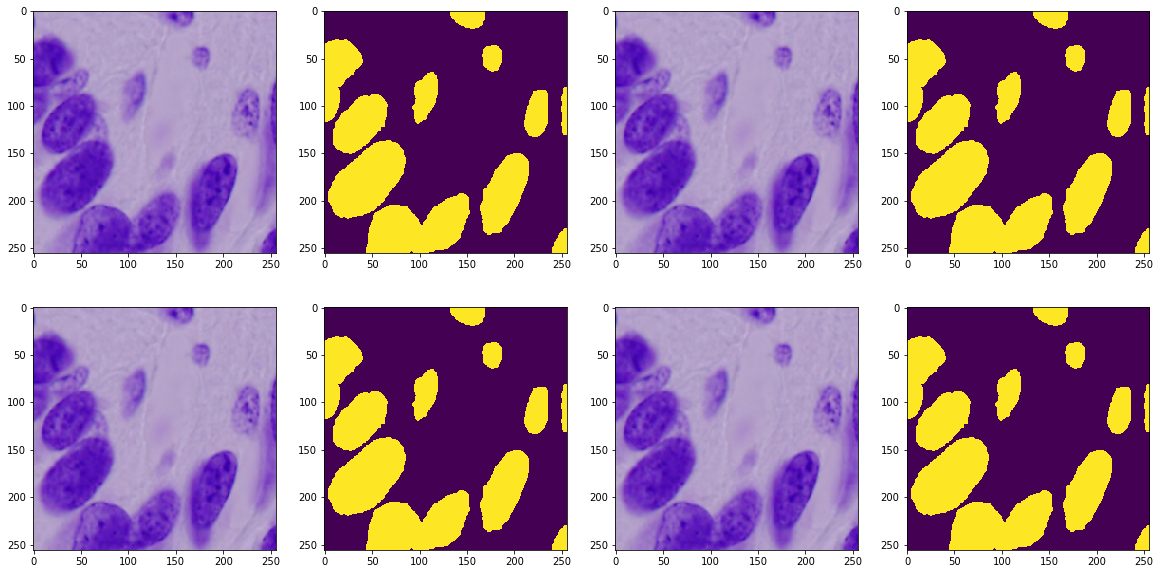

In [172]:
# Check training data
f, axarr = plt.subplots(2,4)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,1].imshow(np.squeeze(Y_train[ix]))

axarr[0,2].imshow(X_train[ix])
axarr[0,3].imshow(np.squeeze(Y_train[ix]))

axarr[1,0].imshow(X_train[ix])
axarr[1,1].imshow(np.squeeze(Y_train[ix]))

axarr[1,2].imshow(X_train[ix])
axarr[1,3].imshow(np.squeeze(Y_train[ix]))

plt.show()

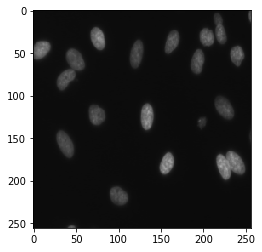

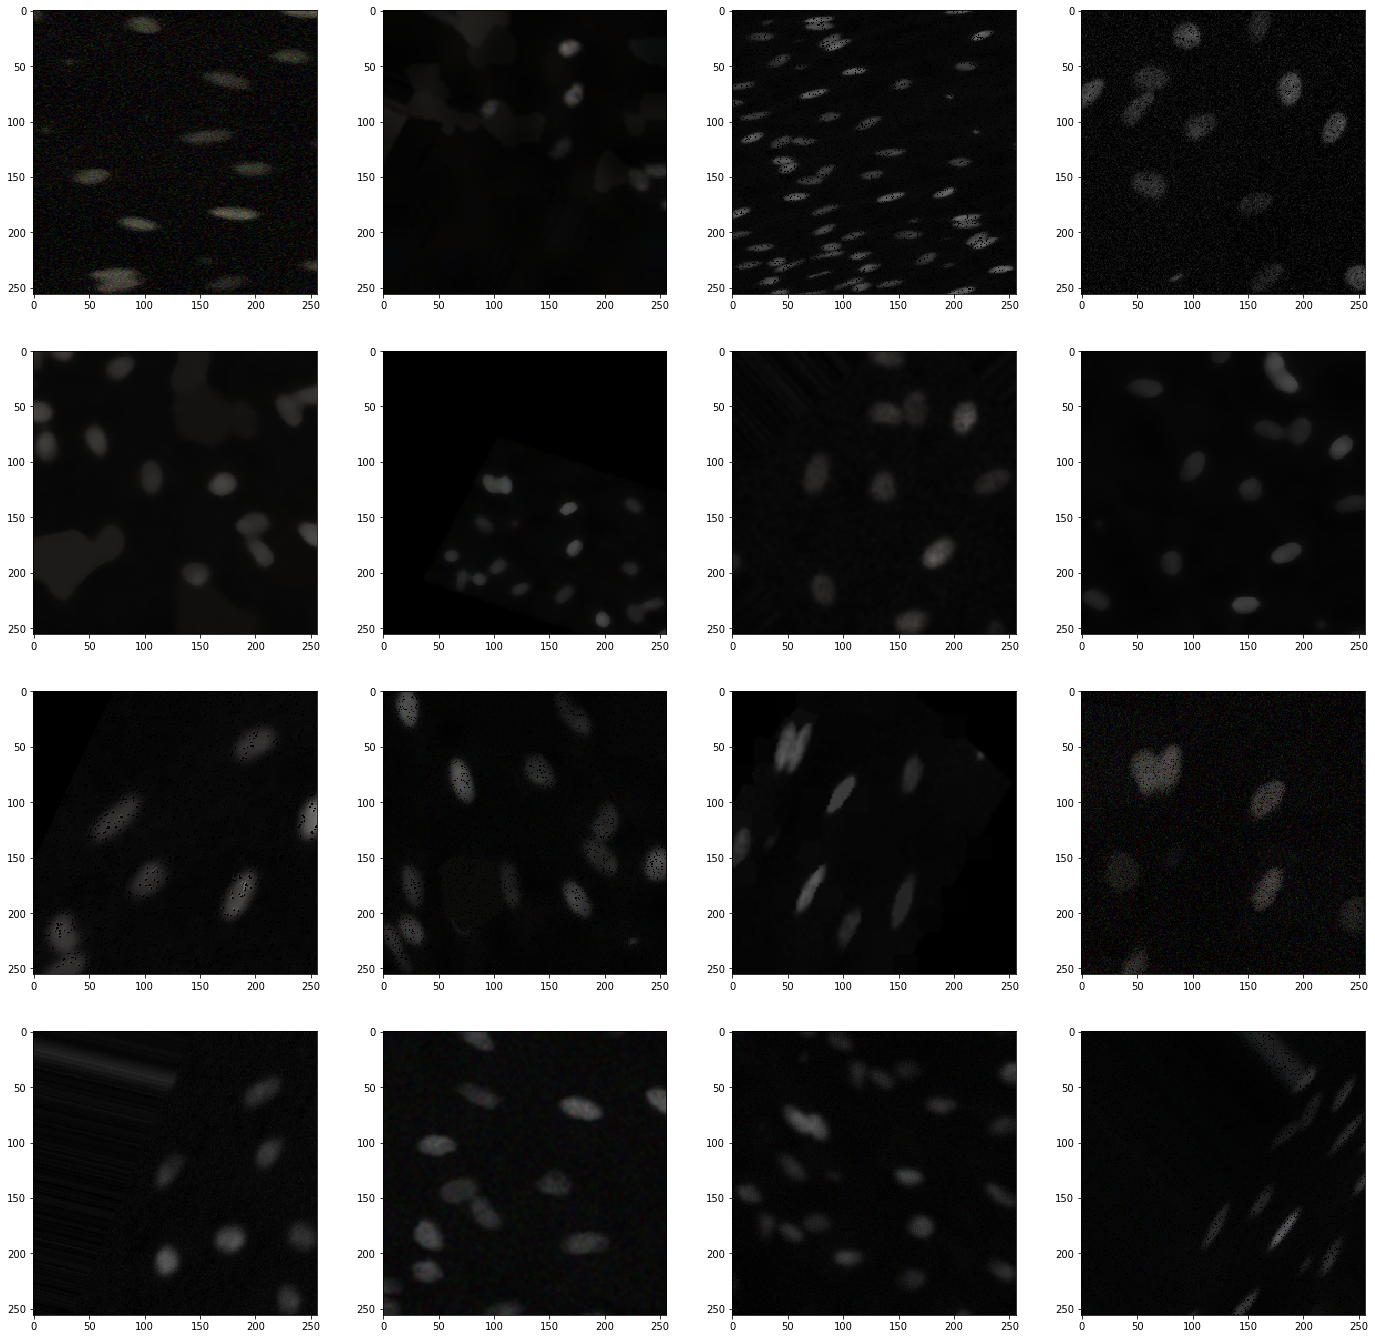

In [178]:
import imgaug as ia
import imgaug.augmenters as iaa

class Imgaug_Data_Generator():
    def __init__(self, data_generator, imgaug_seq):
        self.data_generator = data_generator
        self.imgaug_seq = imgaug_seq
    
    def __len__(self):
        return len(self.data_generator)
    
    def __iter__(self):
        return self

    def __next__(self):
        data = next(self.data_generator)
        aug_imgs = self.imgaug_seq.augment_images(data[0])
        return (aug_imgs, data[1])

sometimes = lambda aug: iaa.Sometimes(.5, aug)
augm_processor = iaa.Sequential(
    [
        iaa.Fliplr(.5), # horizontally flip 50% of all images
        iaa.Flipud(.2), # vertically flip 20% of all images
        iaa.Affine(
            translate_percent={"x": .1, "y": .1},
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            # rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        # iaa.OneOf([
            # iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
            # iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
        # ]),
        # # search either for all edges or for directed edges,
        # # blend the result with the original image using a blobby mask
        # iaa.SimplexNoiseAlpha(iaa.OneOf([
            # iaa.EdgeDetect(alpha=(0.5, 1.0)),
            # iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
        # ])),
        iaa.Dropout((0.05, 0.1)), # randomly remove up to 10% of the pixels
    
    ],
    random_order=True
)

plt.imshow(X_train[0])
plt.show()
plt.pause(.01)

plt.figure(figsize=(24,24))
for i in range(16):
    images_aug = seq.augment_images(X_train[:1])
    plt.subplot(4,4, i+1)
    plt.imshow(images_aug[0])
plt.show()
plt.pause(.01)

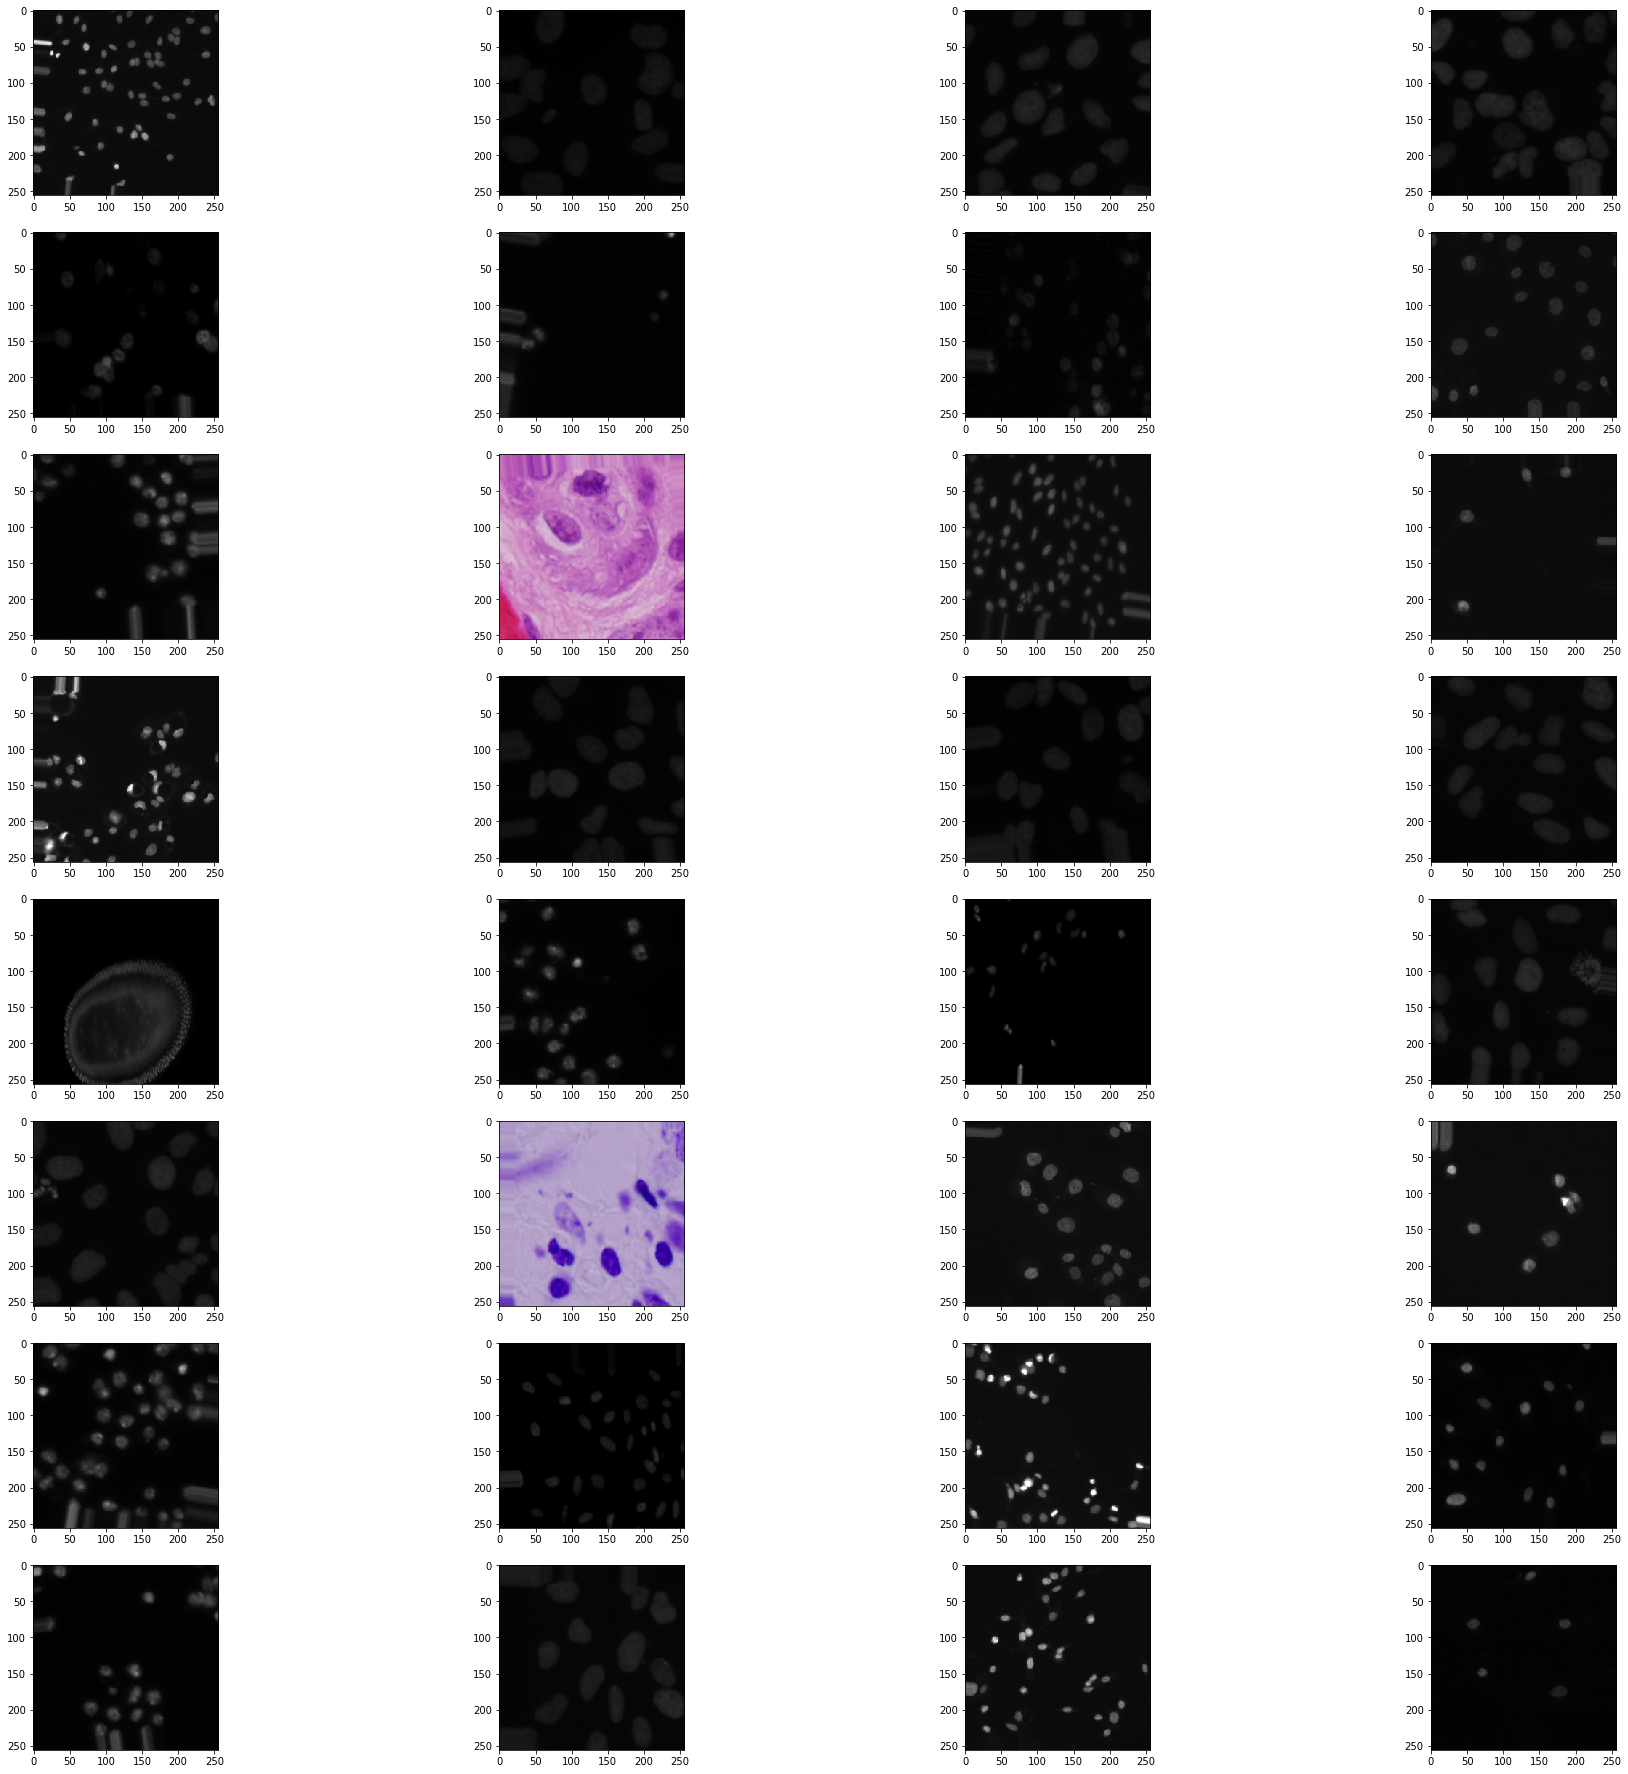

In [186]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.15,
    height_shift_range=0.15,
    validation_split=0.1, # set validation split
    channel_shift_range=.5,
    horizontal_flip=False)

train_generator = train_datagen.flow(
    X_train, Y_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    subset='training',
)
test_generator = train_datagen.flow(
    X_train, Y_train, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    subset='validation',
)

# train_generator = Imgaug_Data_Generator(train_generator, augm_processor)

plt.figure(figsize=(32,32))
imgs = next(train_generator)
for (i, im) in enumerate(imgs[0][:32]):
    # print(im.shape)
    plt.subplot(8,4, i+1)
    plt.imshow(im)
plt.show()

In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

# 2. Build model

> Построим U-Net model, по мотивам [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) и близко к этому [репозиторию](https://github.com/jocicmarko/ultrasound-nerve-segmentation) из Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [0]:
def make_unet_version_1():
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    #c5 = BatchNormalization() (c5)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    return inputs, outputs

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [183]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://d6a61e40.ngrok.io


In [189]:
reset_tf_session()

inputs, outputs = make_unet_version_1()
model = Model(inputs=[inputs], outputs=[outputs])
optimizer = Adam(lr=LR,)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[f1_m])

checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['f1_m'] , verbose = 1  , mode = 'max')
earlyStoping = EarlyStopping()

cycle_lr = CyclicLR(base_lr=.001, max_lr=.0001, step_size=len(train_generator), gamma=.98)
# cbs = [checkpoint, TensorBoardColabCallback(tbc), cycle_lr]
cbs = [checkpoint, TensorBoardColabCallback(tbc)]
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = len(test_generator),
    validation_data = test_generator, 
    validation_steps = len(test_generator),
    epochs = NUM_EPOCHS,
    callbacks = cbs,
)

Epoch 1/50
3/3 [==============================] - 4s 1s/step - loss: 0.5838 - f1_m: 0.0954 - val_loss: 0.5222 - val_f1_m: 2.0634e-05

Epoch 00001: saving model to best_model.hdf5
Epoch 2/50
3/3 [==============================] - 3s 967ms/step - loss: 0.4877 - f1_m: 0.0456 - val_loss: 0.4829 - val_f1_m: 0.0000e+00

Epoch 00002: saving model to best_model.hdf5
Epoch 3/50
3/3 [==============================] - 3s 975ms/step - loss: 0.4494 - f1_m: 0.0115 - val_loss: 0.4641 - val_f1_m: 0.0000e+00

Epoch 00003: saving model to best_model.hdf5
Epoch 4/50
3/3 [==============================] - 3s 915ms/step - loss: 0.4540 - f1_m: 0.0033 - val_loss: 0.4570 - val_f1_m: 0.0000e+00

Epoch 00004: saving model to best_model.hdf5
Epoch 5/50
3/3 [==============================] - 3s 950ms/step - loss: 0.4327 - f1_m: 0.0030 - val_loss: 0.4529 - val_f1_m: 0.0000e+00

Epoch 00005: saving model to best_model.hdf5
Epoch 6/50
3/3 [==============================] - 3s 966ms/step - loss: 0.4382 - f1_m: 8.0640

KeyboardInterrupt: ignored

In [0]:
model.save('keras_unet.h5')

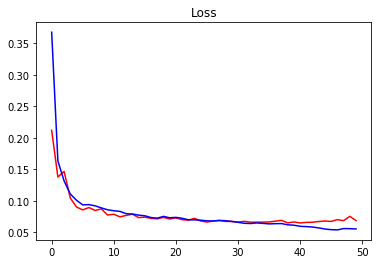

In [0]:
def plot_loss_history(history):
    # validation losses
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.show()
    
plot_loss_history(history)

# 3. Make predictions

In [0]:
!ls

DRIVE  input  keras_unet.h5  sample_data


In [0]:
# Use model to predict train labels
model = load_model('keras_unet.h5', compile=False)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[f1_m])
Y_predict = model.predict(X_train, verbose=1)
Y_predict.shape

670/670 [==============================] - 7s 10ms/step


(670, 256, 256, 1)

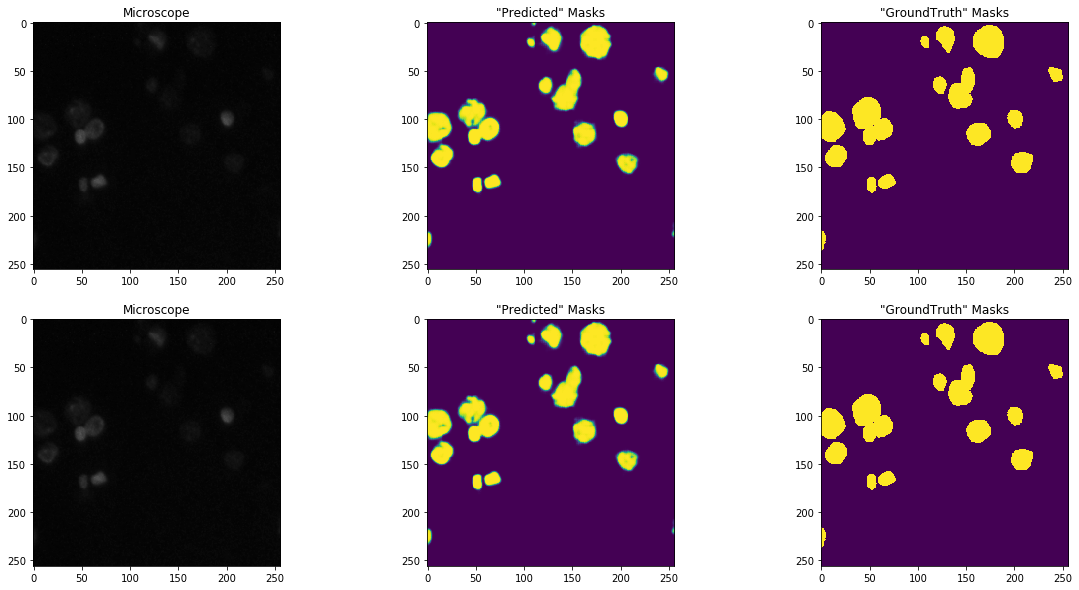

In [0]:
# Check predict data
f, axarr = plt.subplots(2,3)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,0].set_title('Microscope')
axarr[0,1].imshow(np.squeeze(Y_predict[ix]))
axarr[0,1].set_title('"Predicted" Masks')
axarr[0,2].imshow(np.squeeze(Y_train[ix]))
axarr[0,2].set_title('"GroundTruth" Masks')

axarr[1,0].imshow(X_train[ix])
axarr[1,0].set_title('Microscope')
axarr[1,1].imshow(np.squeeze(Y_predict[ix]))
axarr[1,1].set_title('"Predicted" Masks')
axarr[1,2].imshow(np.squeeze(Y_train[ix]))
axarr[1,2].set_title('"GroundTruth" Masks')

plt.show()

Смотриться хорошо

In [0]:
# Get test data
X_test = get_X_data(TEST_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))

# Use model to predict test labels
Y_hat = model.predict(X_test, verbose=1)
Y_hat.shape

65/65 [==============================] - 1s 17ms/step


(65, 256, 256, 1)

(256, 256, 3)


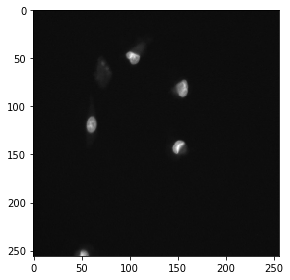

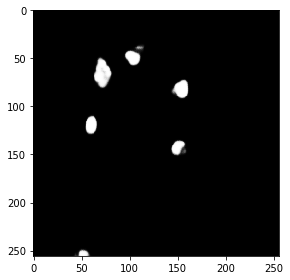

In [0]:
idx = random.randint(0, len(test_ids[1]))
print(X_test[idx].shape)
skimage.io.imshow(X_test[idx])
plt.show()
skimage.io.imshow(Y_hat[idx][:,:,0])
plt.show()

# 4. Encode and Submit

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

мы ресайзили картинку до 256х256, но чтоб верно предсказать, нам нужно сделать маску под размер изначальной картинки

In [0]:
# Upsample Y_hat back to the original X_test size (height and width)
Y_hat_upsampled = []
for i, test_id in enumerate(os.listdir(TEST_PATH)):  #loop through test_ids in the test_path
    img = skimage.io.imread('{0}/{1}/images/{1}.png'.format(TEST_PATH, test_id))  #read original test image directly from path
    img_upscaled = skimage.transform.resize(Y_hat[i], (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)  #upscale Y_hat image according to original test image
    Y_hat_upsampled.append(img_upscaled)   #append upscaled image to Y_hat_upsampled
print(len(Y_hat_upsampled))
print(Y_hat_upsampled[1].shape)

65
(256, 256, 1)


Осталось закодировать нашу маску

In [0]:
# Apply Run-Length Encoding on our Y_hat_upscaled
new_test_ids = []
rles = []
for n, id_ in enumerate(os.listdir(TEST_PATH)):
    rle = list(prob_to_rles(Y_hat_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
len(new_test_ids)  #note that for each test_image, we can have multiple entries of encoded pixels

2428

In [0]:
len(rles[1])

24

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)

In [0]:
sub.head()

ImageId                                      EncodedPixels
0  1ef68e93964c2d9230100c1347c328f6385a7bc027879d...                            135 8 391 7 647 6 904 1
1  1ef68e93964c2d9230100c1347c328f6385a7bc027879d...  166 10 421 11 676 13 932 13 1188 13 1444 14 16...
2  1ef68e93964c2d9230100c1347c328f6385a7bc027879d...  1167 4 1421 7 1676 10 1930 13 2186 13 2441 15 ...
3  1ef68e93964c2d9230100c1347c328f6385a7bc027879d...  1787 6 2041 8 2296 9 2551 10 2807 10 3063 10 3...
4  1ef68e93964c2d9230100c1347c328f6385a7bc027879d...  5391 9 5646 11 5901 13 6157 13 6412 14 6668 15...

In [0]:
len(sub)

2428

Готово!

## Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Добавить свою метрику (для сегментации loss не лучшая метрика) и callbacks по ней
* Поставить и подобрать Threshold для predictions
* Добавить аугментацию
* Поиграться с архитектурой
* Подобрать другие переменные (размер картинки, батч и тп)
* Добавить политику обучения
* Добавить TTA
* Найти и обучиться на других внешних данных
* Построить ансамбль из разных архитектур

Удачи в соревновании!